In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
#loading data
data = pd.read_csv('/kaggle/input/heart-failure/cardio_train.csv')
print(data)

      id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio
0                  0;18393;2;168;62.0;110;80;1;1;0;0;1;0                               
1                  1;20228;1;156;85.0;140;90;3;1;0;0;1;1                               
2                  2;18857;1;165;64.0;130;70;3;1;0;0;0;1                               
3                 3;17623;2;169;82.0;150;100;1;1;0;0;1;1                               
4                  4;17474;1;156;56.0;100;60;1;1;0;0;0;0                               
...                                                  ...                               
69995          99993;19240;2;168;76.0;120;80;1;1;1;0;1;0                               
69996         99995;22601;1;158;126.0;140;90;2;2;0;0;1;1                               
69997         99996;19066;2;183;105.0;180;90;3;1;0;1;0;1                               
69998          99998;22431;1;163;72.0;135;80;1;2;0;0;0;1                               
69999          99999;20540;1;170

In [3]:
# Step 1: Load the data with the correct delimiter
data = pd.read_csv('/kaggle/input/heart-failure/cardio_train.csv', delimiter=';')
# print(data)

# Step 2: Check for any missing or NaN values
# print(data.isna().sum())
data = data.fillna(data.mean())  # Replace NaN values with column mean 
# print(data)
# print(data.dtypes)
data = data.drop(columns=['id'])
# data = data.drop(columns=["\\"])
# print(data)
# print(data.describe())


# print (data.describe())
print(data.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB
None


<Axes: xlabel='cardio', ylabel='count'>

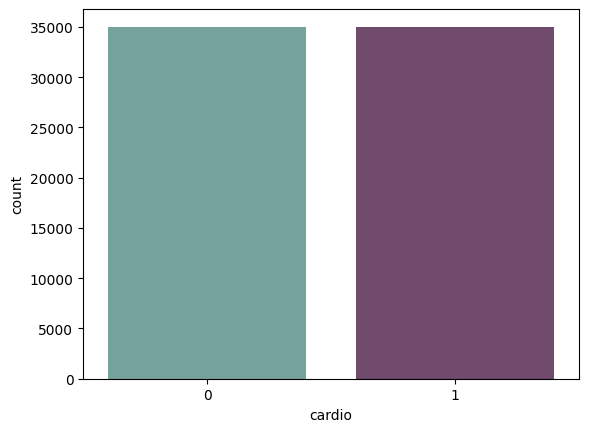

In [4]:
#evaluate the traget and find out if data is imbalance
cols= ["#6daa9f","#774571"]
sns.countplot(x= data["cardio"], palette= cols)


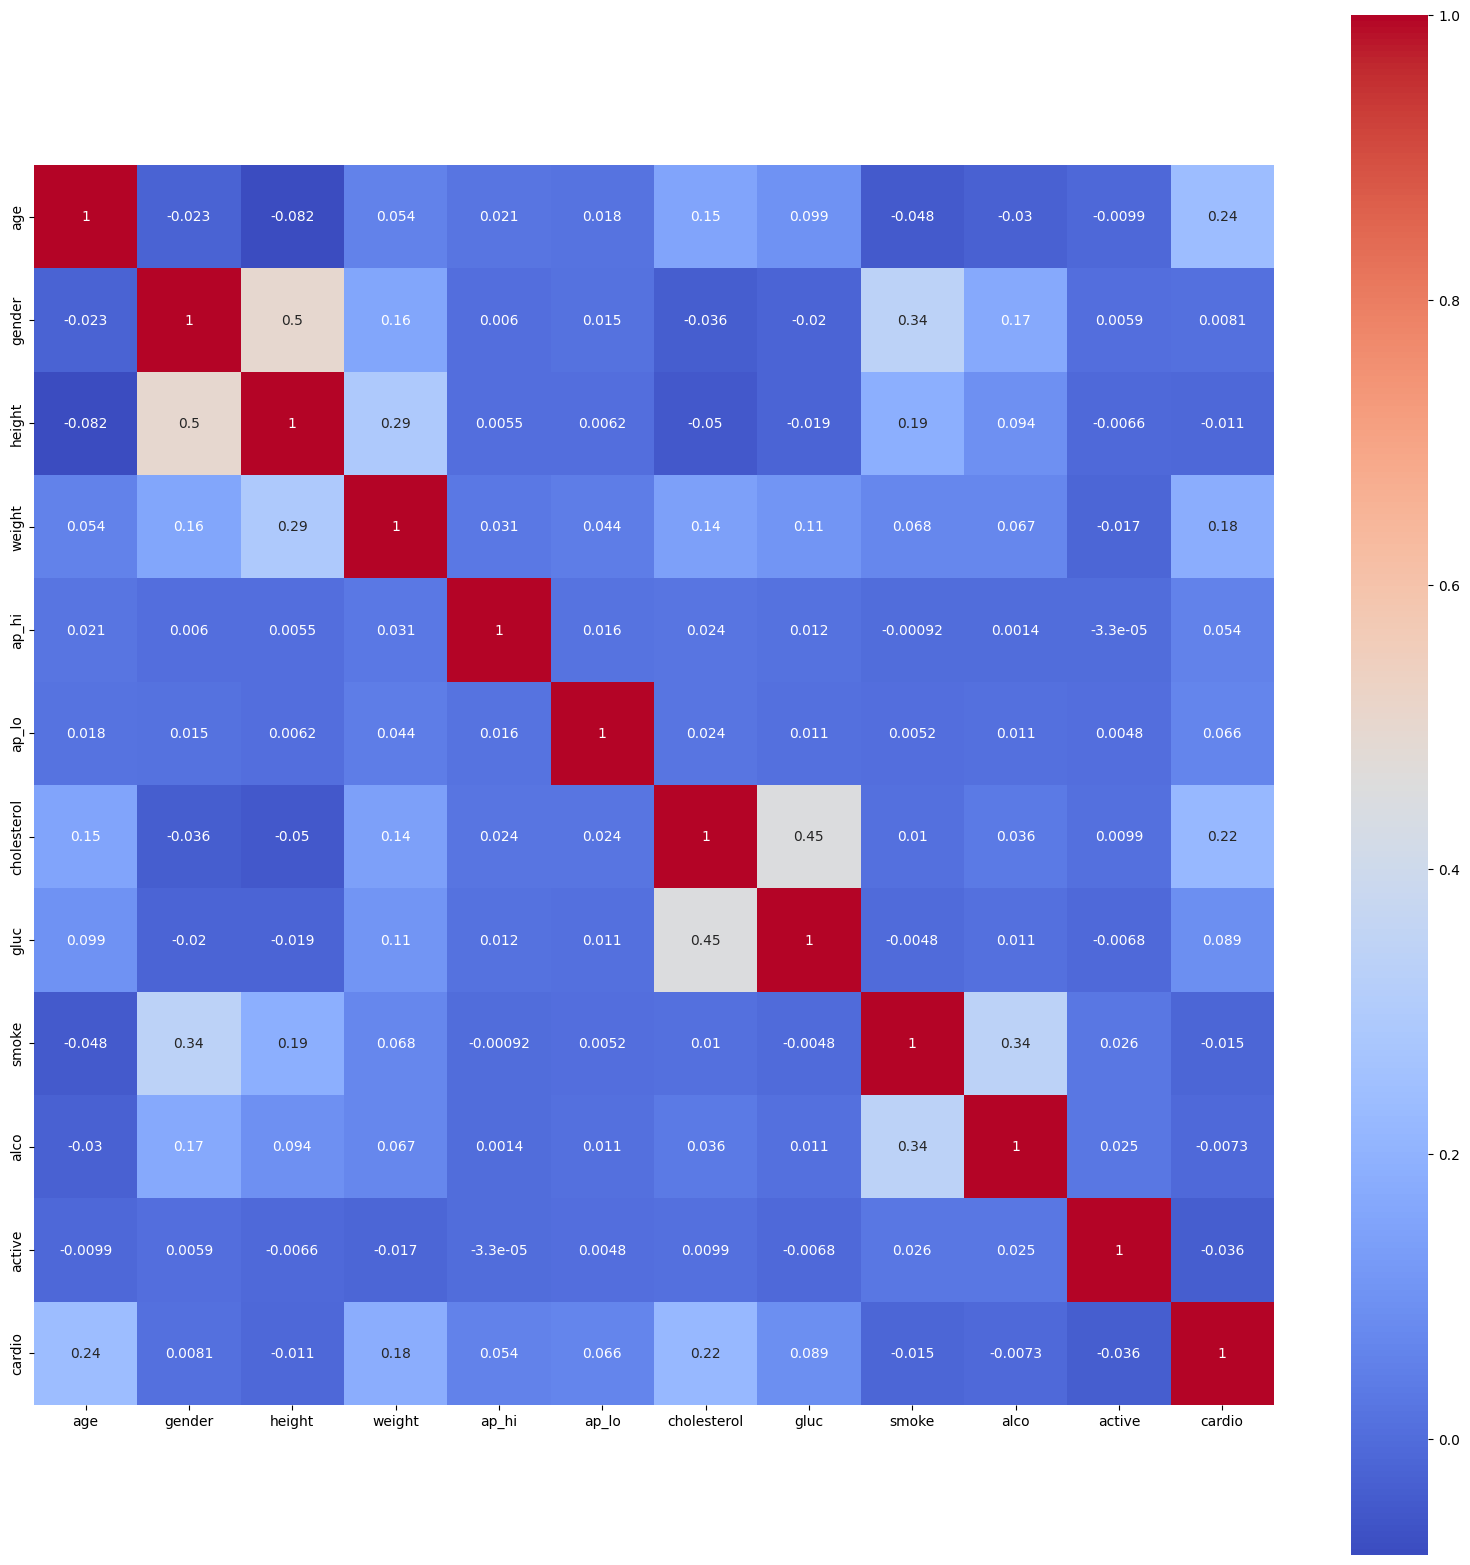

In [5]:
#Examaning a corelation matrix of all the features 

corrmat = data.corr()
plt.subplots(figsize=(20,20))
sns.heatmap(corrmat,cmap= 'coolwarm',annot=True, square=True);

In [6]:
# remove invalid values
data = data[(data['ap_lo'] <= 300) & (data['ap_lo'] >= 0)]
print(data[data['ap_lo'] >= 0])  # Just to confirm rows where ap_hi is non-negative

         age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0      18393       2     168    62.0    110     80            1     1      0   
1      20228       1     156    85.0    140     90            3     1      0   
2      18857       1     165    64.0    130     70            3     1      0   
3      17623       2     169    82.0    150    100            1     1      0   
4      17474       1     156    56.0    100     60            1     1      0   
...      ...     ...     ...     ...    ...    ...          ...   ...    ...   
69995  19240       2     168    76.0    120     80            1     1      1   
69996  22601       1     158   126.0    140     90            2     2      0   
69997  19066       2     183   105.0    180     90            3     1      0   
69998  22431       1     163    72.0    135     80            1     2      0   
69999  20540       1     170    72.0    120     80            2     1      0   

       alco  active  cardio  
0        

In [7]:
# remove invalid values
data = data[(data['ap_hi'] <= 300) & (data['ap_hi'] >= 0)]
print(data[data['ap_hi'] >= 0])  # Just to confirm rows where ap_hi is non-negative

         age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0      18393       2     168    62.0    110     80            1     1      0   
1      20228       1     156    85.0    140     90            3     1      0   
2      18857       1     165    64.0    130     70            3     1      0   
3      17623       2     169    82.0    150    100            1     1      0   
4      17474       1     156    56.0    100     60            1     1      0   
...      ...     ...     ...     ...    ...    ...          ...   ...    ...   
69995  19240       2     168    76.0    120     80            1     1      1   
69996  22601       1     158   126.0    140     90            2     2      0   
69997  19066       2     183   105.0    180     90            3     1      0   
69998  22431       1     163    72.0    135     80            1     2      0   
69999  20540       1     170    72.0    120     80            2     1      0   

       alco  active  cardio  
0        

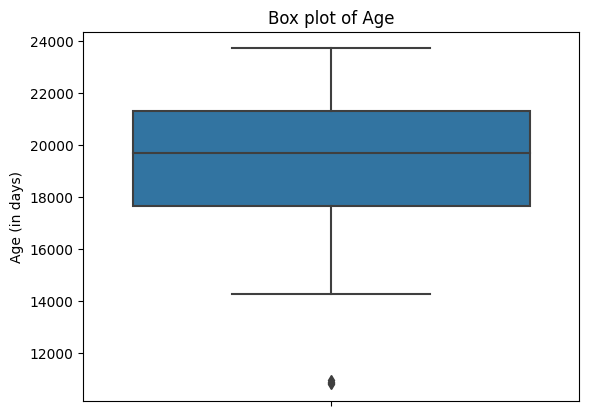

In [8]:
sns.boxplot(y=data['age'])
plt.title("Box plot of Age")
plt.ylabel("Age (in days)")
plt.show()

In [9]:
data['age_years'] = np.floor(data['age'] / 365)
print(data)

         age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0      18393       2     168    62.0    110     80            1     1      0   
1      20228       1     156    85.0    140     90            3     1      0   
2      18857       1     165    64.0    130     70            3     1      0   
3      17623       2     169    82.0    150    100            1     1      0   
4      17474       1     156    56.0    100     60            1     1      0   
...      ...     ...     ...     ...    ...    ...          ...   ...    ...   
69995  19240       2     168    76.0    120     80            1     1      1   
69996  22601       1     158   126.0    140     90            2     2      0   
69997  19066       2     183   105.0    180     90            3     1      0   
69998  22431       1     163    72.0    135     80            1     2      0   
69999  20540       1     170    72.0    120     80            2     1      0   

       alco  active  cardio  age_years 

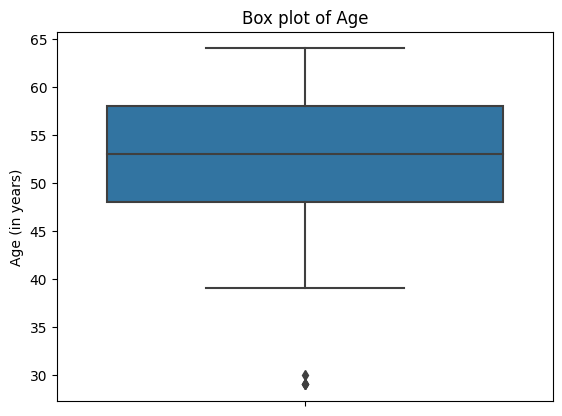

In [10]:
sns.boxplot(y=data['age_years'])
plt.title("Box plot of Age")
plt.ylabel("Age (in years)")
plt.show()

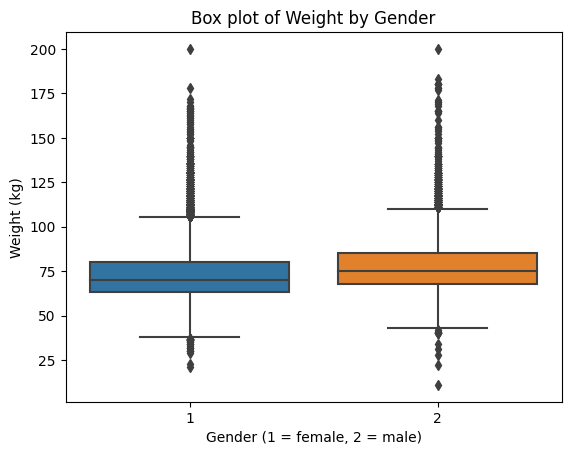

In [11]:
sns.boxplot(x='gender', y='weight', data=data)
plt.title("Box plot of Weight by Gender")
plt.xlabel("Gender (1 = female, 2 = male)")
plt.ylabel("Weight (kg)")
plt.show()

In [12]:
# remove invalid values
data = data[(data['ap_lo'] <= 300) & (data['ap_lo'] >= 0)]
print(data[data['ap_lo'] >= 0])  # Just to confirm rows where ap_hi is non-negative

         age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0      18393       2     168    62.0    110     80            1     1      0   
1      20228       1     156    85.0    140     90            3     1      0   
2      18857       1     165    64.0    130     70            3     1      0   
3      17623       2     169    82.0    150    100            1     1      0   
4      17474       1     156    56.0    100     60            1     1      0   
...      ...     ...     ...     ...    ...    ...          ...   ...    ...   
69995  19240       2     168    76.0    120     80            1     1      1   
69996  22601       1     158   126.0    140     90            2     2      0   
69997  19066       2     183   105.0    180     90            3     1      0   
69998  22431       1     163    72.0    135     80            1     2      0   
69999  20540       1     170    72.0    120     80            2     1      0   

       alco  active  cardio  age_years 

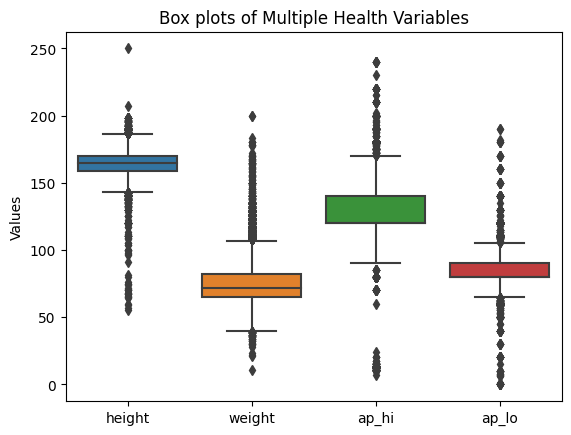

In [13]:
subset = data[['height', 'weight', 'ap_hi', 'ap_lo']]
sns.boxplot(data=subset)
plt.title("Box plots of Multiple Health Variables")
plt.ylabel("Values")
plt.show()

In [14]:
X = data.drop(columns=['cardio']).values  # features
y = data['cardio'].values  # target

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [18]:
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.layer1 = nn.Linear(X.shape[1], 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

In [19]:
model = ANNModel()
criterion = nn.BCELoss()  # for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
epochs = 5000
for epoch in range(epochs):
    model.train()
    
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/5000, Loss: 0.6845
Epoch 2/5000, Loss: 0.6819
Epoch 3/5000, Loss: 0.6794
Epoch 4/5000, Loss: 0.6768
Epoch 5/5000, Loss: 0.6741
Epoch 6/5000, Loss: 0.6714
Epoch 7/5000, Loss: 0.6687
Epoch 8/5000, Loss: 0.6659
Epoch 9/5000, Loss: 0.6630
Epoch 10/5000, Loss: 0.6601
Epoch 11/5000, Loss: 0.6571
Epoch 12/5000, Loss: 0.6541
Epoch 13/5000, Loss: 0.6509
Epoch 14/5000, Loss: 0.6477
Epoch 15/5000, Loss: 0.6445
Epoch 16/5000, Loss: 0.6412
Epoch 17/5000, Loss: 0.6379
Epoch 18/5000, Loss: 0.6345
Epoch 19/5000, Loss: 0.6311
Epoch 20/5000, Loss: 0.6276
Epoch 21/5000, Loss: 0.6242
Epoch 22/5000, Loss: 0.6207
Epoch 23/5000, Loss: 0.6173
Epoch 24/5000, Loss: 0.6139
Epoch 25/5000, Loss: 0.6106
Epoch 26/5000, Loss: 0.6073
Epoch 27/5000, Loss: 0.6041
Epoch 28/5000, Loss: 0.6009
Epoch 29/5000, Loss: 0.5979
Epoch 30/5000, Loss: 0.5950
Epoch 31/5000, Loss: 0.5922
Epoch 32/5000, Loss: 0.5896
Epoch 33/5000, Loss: 0.5871
Epoch 34/5000, Loss: 0.5847
Epoch 35/5000, Loss: 0.5825
Epoch 36/5000, Loss: 0.5805
E

In [21]:
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor)
    predicted = (preds >= 0.5).float()
    accuracy = (predicted.eq(y_test_tensor).sum() / y_test_tensor.shape[0]).item()
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 72.41%
